## Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip3 install h5py
!pwd

/content


## Setting & Import

In [0]:
#Generator
import os
import csv
import cv2
import ast 
import numpy as np 
import pandas as pd
from glob import glob
from tqdm import tqdm #used for progress bar
from PIL import Image, ImageDraw  #PIL:python imaging library
from dask import bag  #a tool for accelerating data processing
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
###################################
from keras.backend import clear_session
from keras.layers import Activation, Reshape
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from tensorflow.keras.metrics import top_k_categorical_accuracy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.backend import clear_session
from keras.models import load_model

In [0]:
def draw_it(strokes):
  image = Image.new("P", (256,256), color=255)
  image_draw = ImageDraw.Draw(image)
  for stroke in ast.literal_eval(strokes):
    for i in range(len(stroke[0])-1): #number of positions , since # of x_coordinates = # of y_coordinates , just loop all x coordinates 
      image_draw.line([stroke[0][i],  #numeric values like [x, y, x, y, ...] 
                       stroke[1][i],
                       stroke[0][i+1], 
                       stroke[1][i+1]],
                       fill=0, width=5) #Color to use for the point
  image = image.resize((imheight, imwidth))
  return 255-np.array(image)
  
def csvWriter(file_name, nparray):
  example = nparray.tolist()
  with open(file_name+'.csv', 'w', newline='') as csvfile:
     writer = csv.writer(csvfile, delimiter=',')
     writer.writerows(example)
     
def save_images(grapharray):
  grapharray = np.reshape(grapharray, (64, 64))
  plt.figure(figsize=(16, 16))
  plt.imshow(grapharray, interpolation='nearest', cmap='gray_r')
  plt.axis('off')
  plt.savefig(final_image_dir + image_label + "/" + image_label + "_{:04d}.png".format(i) )
  csvWriter(final_csv_dir + image_label + "/" + image_label + "_{:04d}".format(i), grapharray)
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

## Definition

In [0]:
image_label = "train"
img_h, img_w = 64, 64
num_examples = 100
num_classes = 30
imheight, imwidth = 64, 64
ims_per_class = 200000

class_paths = glob('/content/drive/My Drive/input/train/*.csv')
generator_path = "./drive/My Drive/output/model/generator/" + image_label + "_generator.h5"
discriminator_path = "./drive/My Drive/output/model/discriminator/" + image_label + "_discriminator.h5"
final_csv_dir = "./drive/My Drive/Final/output/csv/"
final_image_dir = "./drive/My Drive/Final/output/image/"
csv_dir = "./drive/My Drive/output/csv/"
image_dir = "./drive/My Drive/output/image/"
model_path = "./drive/My Drive/output/model/classifier/classifier.h5"

model = keras.models.load_model(model_path, custom_objects={'top_3_accuracy': top_3_accuracy})
np.random.seed(0)
numstonames = {i: v[36:-4].replace(" ", "_") for i, v in enumerate(class_paths)}
print(numstonames)
namestonums = {v:k for k,v in numstonames.items()}

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
{0: 'coffee_cup', 1: 'banana', 2: 'giraffe', 3: 'rain', 4: 'snail', 5: 'belt', 6: 'fork', 7: 'bear', 8: 'marker', 9: 'wine_bottle', 10: 'door', 11: 'paintbrush', 12: 'laptop', 13: 'cactus', 14: 'The_Great_Wall_of_China', 15: 'swan', 16: 'bee', 17: 'hand', 18: 'bed', 19: 'light_bulb', 20: 'raccoon', 21: 'train', 22: 'roller_coaster', 23: 'cake', 24: 'toaster', 25: 'whale', 26: 'spoon', 27: 'key', 28: 'popsicle', 29: 'bandage'}


## Generator: DCGAN

In [0]:
class DCGAN():
  def __init__(self):
      self.img_rows = imheight
      self.img_cols = imwidth
      self.img_shape = (self.img_rows, self.img_cols, 1)
      self.latent_dim = 100
      self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

      # Build and compile the discriminator
      self.discriminator = self.build_discriminator()
      self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)

      # Build and compile the generator
      self.generator = self.build_generator()
      self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      self.gan = self.build_GAN()
  
  def build_GAN(self):
      self.discriminator.trainable = False
      gan_input = Input(shape=(self.latent_dim,))
      img = self.generator(gan_input)
      gan_output = self.discriminator(img)
      gan = Model(gan_input, gan_output, name='GAN')
      gan.compile(loss='binary_crossentropy', optimizer=self.optimizer)
      gan.summary()
      return gan
    
  def build_generator(self):
      generator = Sequential()
      generator.add(Dense(128 * 16 * 16, activation="relu", input_dim=self.latent_dim))
      generator.add(Reshape((16, 16, 128)))
      generator.add(BatchNormalization(momentum=0.8))
      generator.add(UpSampling2D())
      generator.add(Conv2D(128, kernel_size=3, padding="same"))
      generator.add(LeakyReLU(0.2))
      generator.add(BatchNormalization(momentum=0.8))
      generator.add(UpSampling2D())
      generator.add(Conv2D(64, kernel_size=3, padding="same"))
      generator.add(LeakyReLU(0.2))
      generator.add(BatchNormalization(momentum=0.8))

      generator.add(Conv2D(1, kernel_size=3, padding='same', activation = "tanh"))
      generator.summary()
      noise = Input(shape=(self.latent_dim,))
      img = generator(noise)
      return Model(noise, img, name='Generator')

  def build_discriminator(self):
      discriminator = Sequential()
      discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                               input_shape=self.img_shape, kernel_initializer=RandomNormal(stddev=0.02)))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.1))
      discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.1))

      discriminator.add(Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
      discriminator.add(LeakyReLU(0.2))
      discriminator.add(Dropout(0.1))

      discriminator.add(Flatten())
      discriminator.add(Dense(1, activation='sigmoid'))
      discriminator.summary()
      img = Input(shape=self.img_shape)
      validity = discriminator(img)
      return Model(img, validity, name='Discriminator')
 

  def train(self, X_train, epochs, batch_size=128, sample_interval=50):
      ## Load Model
      # if( os.path.isdir(generator_path) ): 
        # print("Generator Model Exist")
      # self.generator = load_model(generator_path)
      # else :
        # print("Generator Model Does Not Exist")
      # if( os.path.isdir(discriminator_path) ): 
        # print("Discriminator Model Exist")
      # self.discriminator = load_model(discriminator_path)
      # else : 
        # print("Discriminator Model Does Not Exist")
      real = np.ones((batch_size, 1))
      fake = np.zeros((batch_size, 1))
      avg_losses = {'D': [], 'G': []}
      num_batches = len(X_train) // batch_size
      for epoch in range(epochs):
          d_loss_acc = 0
          g_loss_acc = 0
          for i in range(num_batches):
            #Random batch of real doodles
            imgs = X_train[np.random.randint(0, len(X_train) - 1, batch_size)]
            #Generate a batch of doodles
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            self.discriminator.trainable = True
            #Train the discriminator (add random smoothing to labels)
            d_loss_real = self.discriminator.train_on_batch(imgs, real * (np.random.uniform(0.7, 1.2)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake + (np.random.uniform(0.0, 0.3)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            #We don't want the discriminator to get updated while the generator is being trained
            self.discriminator.trainable = False
            #Train the generator
            g_loss = self.gan.train_on_batch(noise, real)            
            # if i % 100 == 0:
              # print ("EPOCH:", epoch, "D LOSS", d_loss, "G LOSS:", g_loss)
            d_loss_acc += d_loss
            g_loss_acc += g_loss
          #Print samples
          if (epoch + 1) % sample_interval == 0:
              # self.sample_images(epoch)
              self.test_model()
          if (epoch + 1) % 5 == 0 or epoch == 0:
              self.generator.save(generator_path)
              self.discriminator.save(discriminator_path)
          #Save Image in Final Epoch
          # if(epoch + 1 == epochs):
              # self.save_images(epoch)
          avg_losses['D'].append(d_loss_acc/num_batches)
          avg_losses['G'].append(g_loss_acc/num_batches)
      self.plot_loss(avg_losses)
              
  def sample_images(self, epoch):
    num_examples = 100
    random_noise = np.random.normal(0, 1, size=[num_examples, self.latent_dim])
    generated_images = self.generator.predict(random_noise)
    generated_images = generated_images.reshape(num_examples, 64, 64)*127.5 + 1
    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.suptitle("Samples from G - Epoch = " + str(epoch+1))
    plt.show()  

  def save_images(self, epoch):
    num_examples = 100
    random_noise = np.random.normal(0, 1, size=[num_examples, self.latent_dim])
    generated_images = self.generator.predict(random_noise)
    generated_images = generated_images.reshape(num_examples, 64, 64)*127.5 + 1
    generated_images = np.array(generated_images)
    for i in range(generated_images.shape[0]):
        plt.figure(figsize=(64, 64))
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
        # plt.suptitle("Samples from G - Epoch = " + str(epoch+1))
        plt.savefig("./drive/My Drive/output/image/" + image_label + "/" + image_label + "_{:04d}.png".format(i) )
        im = Image.open("./drive/My Drive/output/image/" + image_label + "/" + image_label + "_{:04d}.png".format(i) )
        im = im.resize((64,64), Image.BILINEAR)
        gray_image = cv2.cvtColor(np.float32(im), cv2.COLOR_BGR2GRAY)
        gray_array = np.array(gray_image)
        gray_array = gray_array / 255.
        # gray_array = gray_array.reshape(1,64,64,1)
        csvWriter("./drive/My Drive/output/csv/" + image_label + "/" + image_label + "_{:04d}".format(i), gray_array)
  def test_model(self):
    gen_model = keras.models.load_model("drive/My Drive/output/model/generator/"+image_label+ "_generator.h5")
    correct_label = image_label.replace(" ", "_")
    print(correct_label)
    latent_dim = 100
    random_noise = np.random.normal(0, 1, size=[num_examples, latent_dim])
    generator_predictions = gen_model.predict(random_noise)
    generator_predictions = generator_predictions.reshape(num_examples, img_h, img_w)
    plt.figure(figsize=(10, 10))
    correct_count = 0

    for i in range(generator_predictions.shape[0]):
      plt.subplot(10, 10, i+1)
      plt.imshow(generator_predictions[i], interpolation='nearest', cmap='gray')
      grapharray = generator_predictions[i]
      for j in range(64):
        for k in range(64):
          if grapharray[j][k] < 0.2 : grapharray[j][k] = 1.
          else: grapharray[j][k] = 0.
      grapharray = np.reshape(grapharray, (1, 64, 64, 1))
      graphpreds = model.predict(grapharray, verbose=0)
      gvs = np.argsort(-graphpreds)
      for idx in gvs[:]:
        print(numstonames[idx[0]], numstonames[idx[1]], numstonames[idx[2]])
        if numstonames[idx[0]] == correct_label : 
          correct_count = correct_count + 1
          # save_images(grapharray)
      plt.axis('off')
    print("Accuracy = ", correct_count / num_examples)
    plt.suptitle("Samples")
    plt.show()

  def plot_loss(self, losses):
      plt.figure(figsize=(10, 8))
      plt.plot(losses["D"], label="Discriminator loss")
      plt.plot(losses["G"], label="Generator loss")
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.title("Loss History")
      plt.show()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0         


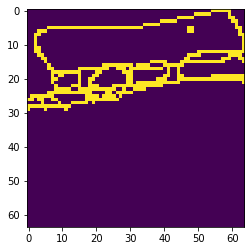

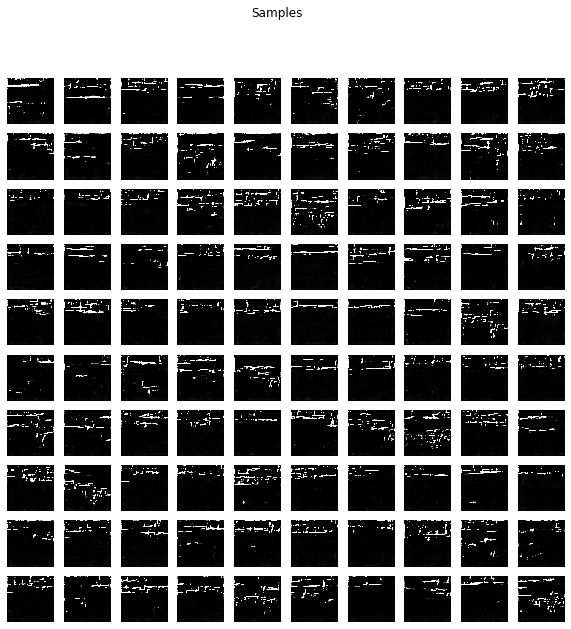

train
light_bulb spoon bed
light_bulb door raccoon
light_bulb door spoon
door light_bulb key
light_bulb spoon raccoon
light_bulb spoon marker
light_bulb door roller_coaster
light_bulb door bear
light_bulb spoon bed
light_bulb spoon door
light_bulb spoon raccoon
light_bulb laptop raccoon
light_bulb spoon door
light_bulb spoon door
light_bulb spoon rain
light_bulb door bear
light_bulb spoon bee
light_bulb swan bear
light_bulb spoon marker
spoon light_bulb door
light_bulb door spoon
light_bulb spoon door
light_bulb swan spoon
light_bulb spoon laptop
light_bulb spoon door
light_bulb spoon door
light_bulb spoon door
light_bulb door bear
light_bulb laptop door
light_bulb door bear
spoon light_bulb bed
light_bulb spoon door
light_bulb bear spoon
roller_coaster light_bulb swan
light_bulb spoon bed
light_bulb door bear
light_bulb spoon door
light_bulb door roller_coaster
light_bulb spoon door
light_bulb spoon door
light_bulb door laptop
light_bulb spoon door
light_bulb spoon roller_coaster
ligh

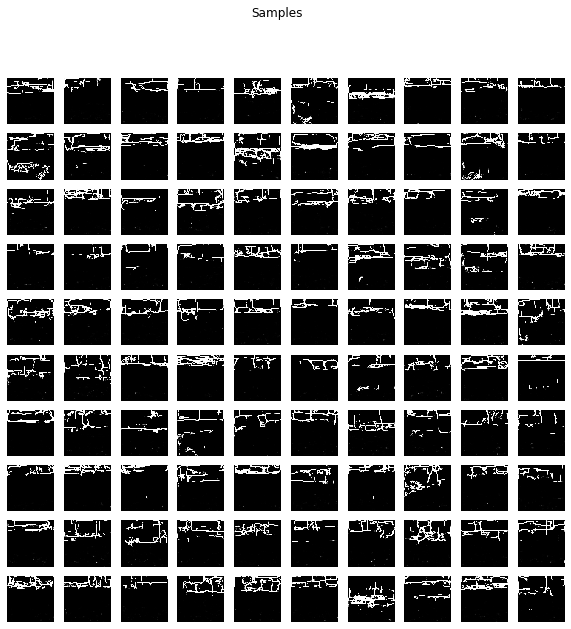

In [0]:
generator_test = pd.read_csv("./drive/My Drive/input/train/" + image_label + ".csv",nrows=ims_per_class)
generator_imagebag = bag.from_sequence(generator_test.drawing.values).map(draw_it)
generator_trainarray = np.array(generator_imagebag.compute())
#shape:(num_images_per_class,64,64)
#print(generator_trainarray.shape)

generator_X_train = ((generator_trainarray.astype(np.float32)/127.5)) - 1. #normalize to be [-1,1]
generator_num_train = generator_X_train.shape[0]
generator_X_train = generator_X_train.reshape(generator_num_train, imheight, imwidth, 1)
# print(generator_X_train.shape)
# print(generator_X_train[0])

random_test = generator_X_train[np.random.randint(generator_num_train-1)].reshape(64, 64)
random_test = random_test*127.5 + 1
plt.imshow(random_test) 

gan = DCGAN()
gan.train(generator_X_train, epochs=50, batch_size=128, sample_interval=5)